# ***Predicting Video Popularity: Use viewCount, likeCount, or commentCount as the target column.***

# Classifying Structured Data using Keras Preprocessing Layers

Understanding the Data Columns

- title: This is text data and can be treated as a categorical feature or used in natural language processing (NLP) models to extract meaningful features.

- publishedAt_timestamp: This timestamp can be used to extract features like hour, day of the week, month, etc., which might correlate with viewer behavior.

- viewCount, likeCount, commentCount: These are numerical features that directly reflect user engagement and can be critical indicators of a video's success.

- tagCount: This numerical feature represents how many tags are associated with the video, which might correlate with its discoverability.

- duration_seconds: A numerical feature indicating the length of the video, which can affect viewer engagement and completion rates.

- caption_False, caption_True: These binary features indicate whether captions are available, which can be important for accessibility and engagement.

- definition_hd, definition_sd: Binary features that indicate the video quality, potentially impacting user engagement.

- publishDayName: This categorical feature can be used to see if videos perform differently depending on the day of the week they are published.


In [1]:
# Install necessary packages
!pip install -U scikit-learn
!pip install isodate==0.6.1
!sudo apt install graphviz -y
!pip install tensorflow

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import isodate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import layers
from tensorflow.keras import layers
from tensorflow.keras.layers import CategoryEncoding, StringLookup, IntegerLookup, Normalization
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
hips = pd.read_csv('/content/drive/MyDrive/snakeHipsAnal/flagrant.csv')

In [4]:
hips.isnull().sum()
hips.dropna()
hips['durationSecs'] = hips['duration'].apply(lambda x: isodate.parse_duration(x))
hips['duration_seconds'] = hips['durationSecs'].dt.total_seconds()

In [5]:
hips.isin([0, np.nan]).sum()

,0
video_id,0
channelTitle,0
title,0
description,0
tags,3
publishedAt,0
viewCount,0
likeCount,0
favouriteCount,489
commentCount,0


In [6]:
hips.isnull().sum()

,0
video_id,0
channelTitle,0
title,0
description,0
tags,3
publishedAt,0
viewCount,0
likeCount,0
favouriteCount,489
commentCount,0


In [7]:
hips['publishedAt'] = pd.to_datetime(hips['publishedAt'])
hips['publishedAt_timestamp'] = hips['publishedAt'].apply(lambda x: x.timestamp())
hips = hips.replace('\$', '', regex=True)
hips['publishDayName'] = hips['pushblishDayName']

### Feature Selection

This section focuses on selecting the relevant features for the machine learning model. We create a list named `columns_to_keep` that includes the following columns:

*   `title`
*   `publishedAt_timestamp`
*   `viewCount`
*   `likeCount`
*   `commentCount`
*   `tagCount`
*   `duration_seconds`
*   `publishDayName`
*   `definition`
*   `caption`

These columns are considered relevant for predicting video popularity and will be used for further analysis. The code then filters the `hips` DataFrame to keep only these selected columns.

In [8]:
columns_to_keep = [
    'title', 'publishedAt_timestamp', 'viewCount', 'likeCount',
    'commentCount', 'tagCount', 'duration_seconds', 'publishDayName', 'definition', 'caption'
]

# Keep only the relevant columns
hips = hips[columns_to_keep]

# Feature Engineering

This section focuses on creating new features from the existing ones to potentially improve the model's performance. Two new features are engineered:

In [9]:
# View count per like
hips['view_per_like'] = hips['viewCount'] / hips['likeCount']

# Comment count multiplied by duration
hips['comment_duration_interaction'] = hips['commentCount'] * hips['duration_seconds']

# Handle potential division by zero
hips['view_per_like'] = hips['view_per_like'].fillna(0)


- **view_per_like**: This feature represents the ratio of views to likes for each video. It's calculated by dividing the **viewCount** by the **likeCount**.

- **comment_duration_interaction**: This feature captures the interaction between the number of comments and the video's duration. It's calculated by multiplying the commentCount by the **duration_seconds**.

To handle potential division by zero errors when calculating **view_per_like**, any missing values resulting from division by zero are filled with 0 using the **fillna()** method.

For convenience and brevity, the `hips` DataFrame is assigned to the variable `df`. This shorter variable name will be used in subsequent code.

In [10]:
df = hips

### Creating Target Variable and Data Cleaning

This section defines the target variable for the machine learning model and performs some data cleaning.

In [11]:
# Define a composite score for popularity (e.g., a weighted sum of views, likes, and comments)
df['popularity_score'] = df['viewCount'] + df['likeCount'] * 10 + df['commentCount'] * 20

threshold = df['popularity_score'].median()
df['target'] = np.where(df['popularity_score'] > threshold, 1, 0)

# Drop unused columns
df = df.drop(columns=['title', 'publishedAt_timestamp', 'popularity_score', 'caption'], errors='ignore')

*   **Popularity Score:** A new column named `popularity_score` is created to represent the overall popularity of each video. This score is calculated as a weighted sum of `viewCount`, `likeCount` (weighted by 10), and `commentCount` (weighted by 20).

*   **Target Variable:** A binary target variable named `target` is created based on the `popularity_score`. Videos with a `popularity_score` above the median score are assigned a target value of 1 (popular), while those below or equal to the median are assigned 0 (not popular).

*   **Dropping Columns:** The following columns are dropped from the DataFrame as they are no longer needed for the analysis:

    *   `title`
    *   `publishedAt_timestamp`
    *   `popularity_score`
    *   `caption`

    The `errors='ignore'` argument ensures that the code doesn't raise an error if any of these columns don't exist in the DataFrame.

## Separating Features and Target Variable

This code snippet separates the features (predictor variables) from the target variable in the `df` DataFrame:

In [12]:
X = df.drop('target', axis=1)
y = df['target']

*   **`X = df.drop('target', axis=1)`:** This line creates a new DataFrame `X`  containing all columns from `df` *except* the `target` column.  `X` will hold the features used to predict the target variable.

*   **`y = df['target']`:** This line creates a Series `y` containing only the `target` column from `df`. This is the target variable our machine learning model will try to predict.

In [13]:
cat_col = X.select_dtypes(include='object').columns
cat_col

Index(['publishDayName', 'definition'], dtype='object')

*  **`cat_col = X.select_dtypes(include='object').columns`:**  This line selects columns with the data type 'object', which usually represents categorical data in pandas. The result is stored in the `cat_col` variable, which now contains a list of categorical column names.

### One-Hot Encoding Categorical Features

This code block performs one-hot encoding on the categorical features identified in the previous step:


In [14]:
X = pd.get_dummies(X, columns=cat_col, drop_first=False)
print(X.shape)
X.head(10)

(489, 15)


,viewCount,likeCount,commentCount,tagCount,duration_seconds,view_per_like,comment_duration_interaction,publishDayName_Friday,publishDayName_Monday,publishDayName_Saturday,publishDayName_Sunday,publishDayName_Thursday,publishDayName_Tuesday,publishDayName_Wednesday,definition_hd
0,327141.0,5579.0,1220.0,21,4965.0,58.637928,6057300.0,False,False,False,False,False,False,True,True
1,347137.0,5359.0,876.0,21,7055.0,64.776451,6180180.0,False,False,False,False,False,False,True,True
2,1958497.0,38258.0,3091.0,21,7838.0,51.191829,24227258.0,False,False,False,False,False,False,True,True
3,811634.0,15010.0,2012.0,21,6813.0,54.072885,13707756.0,False,False,False,False,False,False,True,True
4,1076879.0,23519.0,3638.0,21,7898.0,45.787619,28732924.0,False,False,False,False,False,False,True,True
5,964060.0,24251.0,3023.0,21,7489.0,39.753412,22639247.0,False,False,False,False,False,False,True,True
6,557793.0,7669.0,1657.0,21,6313.0,72.733472,10460641.0,False,False,False,False,False,False,True,True
7,761639.0,12270.0,3643.0,21,6327.0,62.073268,23049261.0,False,False,False,False,False,True,False,True
8,753174.0,9710.0,1631.0,21,7540.0,77.566838,12297740.0,False,False,False,False,False,False,True,True
9,1028632.0,12581.0,1397.0,21,9372.0,81.760750,13092684.0,False,False,False,False,False,False,True,True


*   **`X = pd.get_dummies(X, columns=cat_col, drop_first=False)`:** This line uses the `pd.get_dummies()` function to perform one-hot encoding on the DataFrame `X`.
    *   `columns=cat_col` specifies that only the columns listed in `cat_col` should be one-hot encoded.
    *   `drop_first=False` ensures that all categories are represented with separate columns (no baseline category is dropped). This can be important for some machine learning algorithms.
*   **`print(X.shape)`:** This line prints the shape (number of rows and columns) of the modified DataFrame `X` after one-hot encoding.
*   **`X.head(10)`:** This line displays the first 10 rows of the DataFrame `X` to show the result of the one-hot encoding process.

### Splitting Data into Training and Testing Sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

*  **`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)`:**
    *   `X` and `y` are the feature and target DataFrames/Series respectively.
    *   `test_size=0.2` indicates that 20% of the data will be used for testing.
    *   `random_state=42` ensures reproducibility of the split. Using a fixed random state will result in the same split each time the code is run.

This is a common practice in machine learning to evaluate the model's performance on unseen data (the test set) and avoid overfitting.

### Feature Scaling

This code block performs feature scaling using Min-Max scaling:


In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

*   **`scaler = MinMaxScaler()`:** Creates a `MinMaxScaler` object. This scaler will transform the features to a specific range (usually between 0 and 1).

*   **`X_train = scaler.fit_transform(X_train)`:** Fits the scaler to the training data (`X_train`) and transforms it. This means the scaler learns the minimum and maximum values from the training data and applies the scaling.

*   **`X_test = scaler.transform(X_test)`:** Transforms the test data (`X_test`) using the scaler that was fitted on the training data. It's important to use the same scaling parameters from the training data to avoid data leakage.

Feature scaling is often necessary to improve the performance of machine learning algorithms, especially those sensitive to feature scales, such as gradient descent-based algorithms.

### Defining the Model Architecture

This code defines a function `get_model` that creates and compiles a neural network model:

In [17]:
def get_model():
  input_layer = Input(shape=(X_train.shape[1],))

  x = Dense(128, activation='relu')(input_layer)

  x = Dense(64, activation='relu')(x)

  x = Dense(32, activation='relu')(x)

  output_layer = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input_layer, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  return model

*   **`def get_model():`:** Defines a function named `get_model` to encapsulate the model creation process.

*   **`input_layer = Input(shape=(X_train.shape[1],))`:** Creates the input layer of the network, specifying the shape based on the number of features in the training data.

*   **`x = Dense(128, activation='relu')(input_layer)`:** Adds a dense layer with 128 neurons and ReLU activation to the model.

### Creating and Summarizing the Model

This code block creates an instance of the model and displays its summary:

In [18]:
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

*   **`model = get_model()`:** This line calls the `get_model` function defined earlier to create an instance of the neural network model and assigns it to the variable `model`.

*   **`model.summary()`:** This line prints a summary of the created model, including the layers, output shape, and number of parameters for each layer. This summary provides a good overview of the model's architecture and complexity.

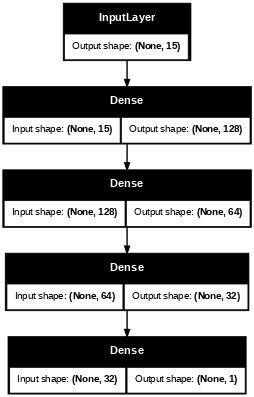

In [19]:
plot_model(model, to_file='model.png', show_shapes=True, dpi=50)

*   **`plot_model(model, to_file='model.png', show_shapes=True, dpi=50)`:** This uses the `plot_model` function (likely from the `keras.utils` module) to create a visual diagram of the model's structure.
    *   `model`: The model to visualize.
    *   `to_file='model.png'`: Saves the diagram to a file named "model.png".
    *   `show_shapes=True`: Displays the shape of the output for each layer in the diagram.
    *   `dpi=50`: Sets the resolution of the image.

Visualizing the model architecture can be helpful for understanding the flow of data through the network and identifying potential areas for improvement.

### Training the Model

This line of code trains the neural network model using the training data:


In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.4733 - loss: 0.6927 - val_accuracy: 0.4783 - val_loss: 0.6828
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4966 - loss: 0.6853 - val_accuracy: 0.4783 - val_loss: 0.6770
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5058 - loss: 0.6789 - val_accuracy: 0.6667 - val_loss: 0.6708
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5809 - loss: 0.6769 - val_accuracy: 0.6667 - val_loss: 0.6652
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5916 - loss: 0.6710 - val_accuracy: 0.6667 - val_loss: 0.6597
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5851 - loss: 0.6693 - val_accuracy: 0.6667 - val_loss: 0.6541
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5792 - loss: 0.6622 - val_accuracy: 0.6812 - val_loss: 0.6485
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5685 - loss: 0.6569 - val_accuracy: 0.6812 - val_loss: 0.6433

`history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)`:** This line uses the `fit` method to train the model.
    *   `X_train` and `y_train` are the training data and labels.
    *   `epochs=100` specifies that the model will be trained for 100 epochs (iterations over the entire dataset).
    *   `batch_size=32` sets the batch size for gradient descent (the number of samples processed before weights are updated).
    *   `validation_split=0.2` reserves 20% of the training data for validation, allowing you to monitor the model's performance on unseen data during training.
    *   `shuffle=True` shuffles the training data before each epoch to prevent the model from learning any order-dependent patterns.
    *   `verbose=1` displays progress information during training.

The training process adjusts the model's weights to minimize the loss function and improve accuracy on the training and validation data. The `history` object stores the training and validation metrics (like loss and accuracy) for each epoch, which can be used to analyze the training process.

This output shows the training metrics for a particular step of the model training process.

*  `0s 6ms/step`: Indicates the time taken for this step.
*  `accuracy: 0.9238`: Shows the training accuracy for this step, meaning the model correctly predicted 92.38% of the training samples.
*  `loss: 0.2114`: Shows the training loss for this step. A lower loss indicates better performance.
*  `val_accuracy: 0.9130`: Shows the validation accuracy, meaning the model correctly predicted 91.3% of the validation samples.
*  `val_loss: 0.1968`: Shows the validation loss.

These metrics suggest that the model is performing well and generalizing to unseen data (validation set), as both training and validation accuracy are high and the losses are relatively low.

### Plotting Training Accuracy/Loss


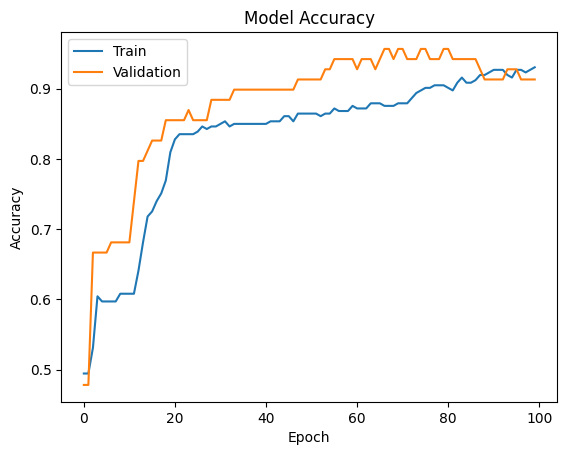

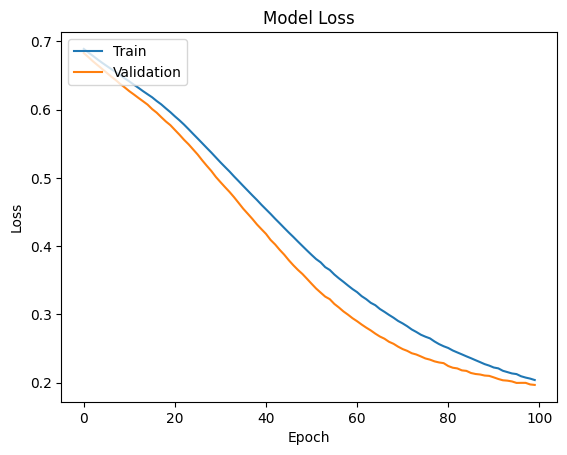

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Making Predictions

This code uses the trained model to predict on the test data:

In [22]:
preds = model.predict(X_test)
preds

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[0.04881375],
       [0.92823213],
       [0.03170099],
       [0.07579716],
       [0.02936242],
       [0.85488814],
       [0.99974513],
       [0.7037245 ],
       [0.0289416 ],
       [0.3819283 ],
       [0.9400528 ],
       [0.96741676],
       [0.0668592 ],
       [0.26646826],
       [0.10191593],
       [0.97921205],
       [0.10802601],
       [0.16207613],
       [0.03420936],
       [0.2864674 ],
       [0.9997621 ],
       [0.76367277],
       [0.07965291],
       [0.99904317],
       [0.99966544],
       [0.99984086],
       [0.99442863],
       [0.05923358],
       [0.6979113 ],
       [0.12447087],
       [0.9899985 ],
       [0.98988724],
       [0.05747817],
       [0.05351245],
       [0.9381253 ],
       [0.9994042 ],
       [0.32342798],
       [0.99971926],
       [0.10370542],
       [0.7317871 ],
       [0.03151618],
       [0.1282321 ],
       [0.03146821],
       [0.99839115],
       [0.82876515],
       [0.5616979 ],
       [0.9063493 ],
       [0.214

his code uses the trained model to predict on the test data:

*   **`preds = model.predict(X_test)`:** This line uses the trained model (`model`) to predict the target variable for the test data (`X_test`). The predictions are stored in the `preds` variable.

*   **`preds`:**  This line (likely in a separate cell) would display the predicted values. The output would be an array of predicted probabilities for each sample in the test set, as this is a binary classification problem with a sigmoid activation in the output layer.

## Converting Predictions to Classes

This code block converts the predicted probabilities from the previous step into class labels (0 or 1):

In [23]:
threshold = 0.5
preds = np.where(preds > threshold, 1, 0)
preds

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
    

*   **`threshold = 0.5`:** Defines a threshold value of 0.5. This is a common threshold for binary classification where probabilities above 0.5 are classified as 1 and those below are classified as 0.

*   **`preds = np.where(preds > threshold, 1, 0)`:** This line uses the `np.where` function to convert probabilities into class labels.
    *   If a prediction in `preds` is greater than the `threshold`, it's assigned a class label of 1.
    *   Otherwise, it's assigned a class label of 0.

*   **`preds`:** (Likely in a separate cell) would display the converted class labels (an array of 0s and 1s).

### Evaluating Model Performance

This code evaluates the performance of the model using a classification report and accuracy score:

In [24]:
print(classification_report(y_test, preds))
print(f"Accuracy: {accuracy_score(y_test, preds)}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.97      0.95      0.96        75

    accuracy                           0.96       147
   macro avg       0.96      0.96      0.96       147
weighted avg       0.96      0.96      0.96       147

Accuracy: 0.9591836734693877


*   **`print(classification_report(y_test, preds))`:** Prints a detailed classification report, including metrics like precision, recall, F1-score, and support for each class (0 and 1 in this case).

*   **`print(f"Accuracy: {accuracy_score(y_test, preds)}")`:** Prints the overall accuracy of the model, which is the ratio of correctly classified samples to the total number of samples.

**Key Metrics:**

* **Precision:**
    * For class 0: 0.95. This means that 95% of the instances predicted as class 0 were actually class 0.
    * For class 1: 0.97. This means that 97% of the instances predicted as class 1 were actually class 1.
* **Recall:**
    * For class 0: 0.97. This means the model correctly identified 97% of the actual instances of class 0.
    * For class 1: 0.95. This means the model correctly identified 95% of the actual instances of class 1.
* **F1-score:** A balanced measure that combines precision and recall.
    * Both classes have an F1-score of 0.96, indicating a good balance between precision and recall.
* **Support:** The number of actual instances in each class (72 for class 0 and 75 for class 1).
* **Accuracy:** The overall accuracy is 0.96, meaning the model correctly classified 96% of the instances in the test set.
* **Macro avg:** The average precision, recall, and F1-score across both classes.
* **Weighted avg:** The weighted average precision, recall, and F1-score, taking into account the number of instances in each class.

**Overall:**

The model demonstrates excellent performance with high precision, recall, and F1-score for both classes. The accuracy of 0.96 indicates that the model is highly effective in classifying instances correctly.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


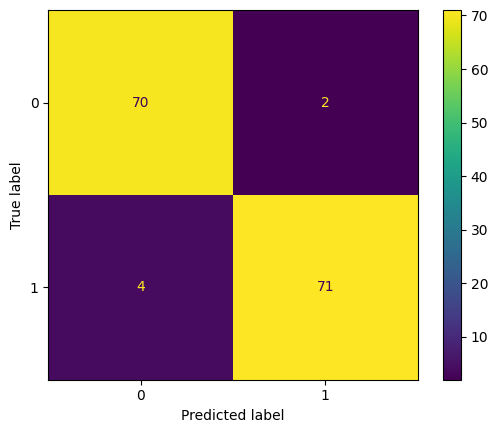

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()